In [1]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [4]:
import os
pwd = os.getcwd()

In [5]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [6]:
emails.count()

file       517401
message    517401
dtype: int64

In [27]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[:500]
print(email_subset.shape)
print(email_subset.head())

(500, 2)
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [28]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [29]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0,
        'print': np.nan
    }

In [30]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [35]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [38]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))

In [39]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)
email_df.head()

,body,to,from_,date,TC,SN,KS,OT,print
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,"Mon, 14 May 2001 16",0,0,0,0,NaN
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,"Fri, 4 May 2001 13",0,0,0,0,NaN
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,"Wed, 18 Oct 2000 03",0,0,0,0,NaN
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,"Mon, 23 Oct 2000 06",0,0,0,0,NaN
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,"Thu, 31 Aug 2000 04",0,0,0,0,NaN


In [40]:
email_df.count()

body     490
to       490
from_    490
date     490
TC       490
SN       490
KS       490
OT       490
print      0
dtype: int64

In [41]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][1]

"Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.My suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time."

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [42]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [43]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [44]:
email_df['text_processed'][1]

'traveling to have a business meeting takes the fun out of the trip especially if you have to prepare a presentation i would suggest holding the business plan meetings here then take a trip without any formal business meetings i would even try and get some honest opinions on whether a trip is even desired or necessaryas far as the business meetings i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not too often the presenter speaks and the others are quiet just waiting for their turn the meetings might be better if held in a round table discussion formatmy suggestion for where to go is austin play golf and rent a ski boat and jet skis flying somewhere takes too much time'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

In [45]:
# Import the wordcloud library
from wordcloud import WordCloud

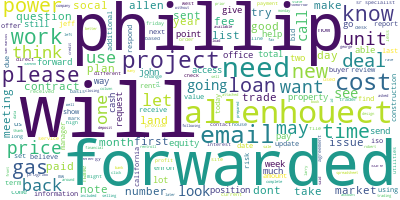

In [46]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [47]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
# X = vect.fit_transform(email_df.text_processed)

In [49]:
email_df.to_pickle('email.pickle')
from IPython.display import clear_output

In [50]:
# def manually_label(email_file):
    
df = pd.read_pickle('email.pickle')
for index, row in df.iterrows():
        print('Is this sentence? Type 1 if team communication,',
              '\nType 2: social networking,','\nType 3:  knowledge sharing and ',
              '\nType 4: others . \n')
        print(row.text_processed)
        label = input()
        print(label)
        if '1' in label:
            df.loc[index, 'TC'] = 1
        if '2' in label:
            df.loc[index, 'SN'] = 1
        if '3' in label:
            df.loc[index, 'KS'] = 1
        if '4' in label:
            df.loc[index, 'OT'] = 1
        if label == '':
            df.loc[index, 'OT'] = 1
        clear_output()
        
        df.to_pickle('email.pickle')
        
print('No more labels to classify!')
    


No more labels to classify!


In [51]:
df.head(5)

,body,to,from_,date,TC,SN,KS,OT,print,text_processed
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com,14 May 2001,1,0,0,0,NaN,here is our forecast
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com,4 May 2001,0,1,0,0,NaN,traveling to have a business meeting takes the...
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com,18 Oct 2000,1,0,0,0,NaN,test successful way to go
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com,23 Oct 2000,1,0,0,0,NaN,randycan you send me a schedule of the salary ...
5,"Greg,How about either next Tuesday or Thursday...",greg.piper@enron.com,phillip.allen@enron.com,31 Aug 2000,0,1,0,0,NaN,greghow about either next tuesday or thursdayp...


In [52]:
df.to_csv(os.path.basename(pwd +'/final_result.csv'))

In [63]:
categories = ['TC','SN','KS','OT']

In [64]:
counts = []
for i in categories:
    counts.append((i, df[i].sum()))

In [65]:
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,TC,307
1,SN,133
2,KS,57
3,OT,43


In [26]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
features = vect.get_feature_names()
print top_feats_in_doc(X, features, 1, 10)

In [ ]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
print(email_df.iloc[11]['text_processed'])

In [ ]:
data = email_df.text_processed.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [ ]:
data_words = list(sent_to_words(data))

In [ ]:
print(data_words[11])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [ ]:
# Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = Phraser(bigram)
# trigram_mod = Phraser(trigram)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
print(bigram_mod[data_words[11]])

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
#  Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [ ]:
data_lemmatized = lemmatization(data_words_bigrams)

In [ ]:
print(data_lemmatized[11])

In [ ]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [ ]:
print('Number of unique words in initital documents:', len(dictionary))

In [ ]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

In [ ]:
texts = data_lemmatized# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]# View

In [ ]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [ ]:
print(corpus[:1])

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [ ]:
from pprint import pprint# number of topics
num_topics = 10# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
#                                            chunksize=500,
                                      per_word_topics=True)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
get_lda_topics(lda_model, 10)

In [ ]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)